<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/QuantumCircuit_ifGate_Qiskit_ibm_runtime_sampler_brisbane_20250127.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
### Qiskit 설치: Windows, 클라우드 환경 ###
%pip install qiskit[visualization]==1.2.4
#%pip install qiskit-ibm-runtime==0.31.0
%pip install qiskit-ibm-runtime==0.30.0
%pip install qiskit-transpiler-service==0.4.10
%pip install qiskit-aer==0.15.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 7.9 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=1f93ad79c038e6c3466ef57896563a1320f69406ed8bd721c5161089d587d412
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
%pip show qiskit qiskit-ibm-runtime qiskit-transpiler-service qiskit-aer

Name: qiskit
Version: 1.2.4
Summary: An open-source SDK for working with quantum computers at the level of extended quantum circuits, operators, and primitives.
Home-page: https://www.ibm.com/quantum/qiskit
Author: 
Author-email: Qiskit Development Team <qiskit@us.ibm.com>
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: dill, numpy, python-dateutil, rustworkx, scipy, stevedore, symengine, sympy, typing-extensions
Required-by: qiskit-aer, qiskit-ibm-runtime, qiskit-qasm3-import, qiskit-transpiler-service
---
Name: qiskit-ibm-runtime
Version: 0.30.0
Summary: IBM Quantum client for Qiskit Runtime.
Home-page: https://github.com/Qiskit/qiskit-ibm-runtime
Author: Qiskit Development Team
Author-email: qiskit@us.ibm.com
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: ibm-platform-services, numpy, pydantic, python-dateutil, qiskit, requests, requests-ntlm, urllib3, websocket-client
Required-by: 
---
Name: qiskit-transpiler-service


In [4]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.primitives import Estimator as QEstimator, Sampler as QSampler, StatevectorSampler, PrimitiveJob
#DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2.
#It will be removed no earlier than 3 months after the release date.
#All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts.
#The V2 alternative for the `Sampler` class is `StatevectorSampler`.

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as RSampler, EstimatorV2 as REstimator, Session, Options
from qiskit_ibm_runtime.fake_provider import FakeManilaV2, FakeBrisbane

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as AerSampler, EstimatorV2 as AerEstimator

from qiskit.visualization import plot_histogram, plot_state_city, plot_state_paulivec, plot_state_hinton


In [6]:
# Connecting runtime account
#service = QiskitRuntimeService(channel="ibm_quantum", token="")
service = QiskitRuntimeService(channel="ibm_quantum", token="4397c934026e2b1262d0a22c90e246544303f133f980737a51242b6c5d2f978f0877bd596f13ecbafd4175c4bc8c1240d2c33bdf0962d5866006211b86e77527")
#backends = service.least_busy(min_num_qubits=2)
#service.backends("ibm_brisbane")
backends=service.backends()
print(backends)

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyiv')>, <IBMBackend('ibm_sherbrooke')>]


In [7]:
backend=service.backends()[0]
print(backend)

<IBMBackend('ibm_brisbane')>


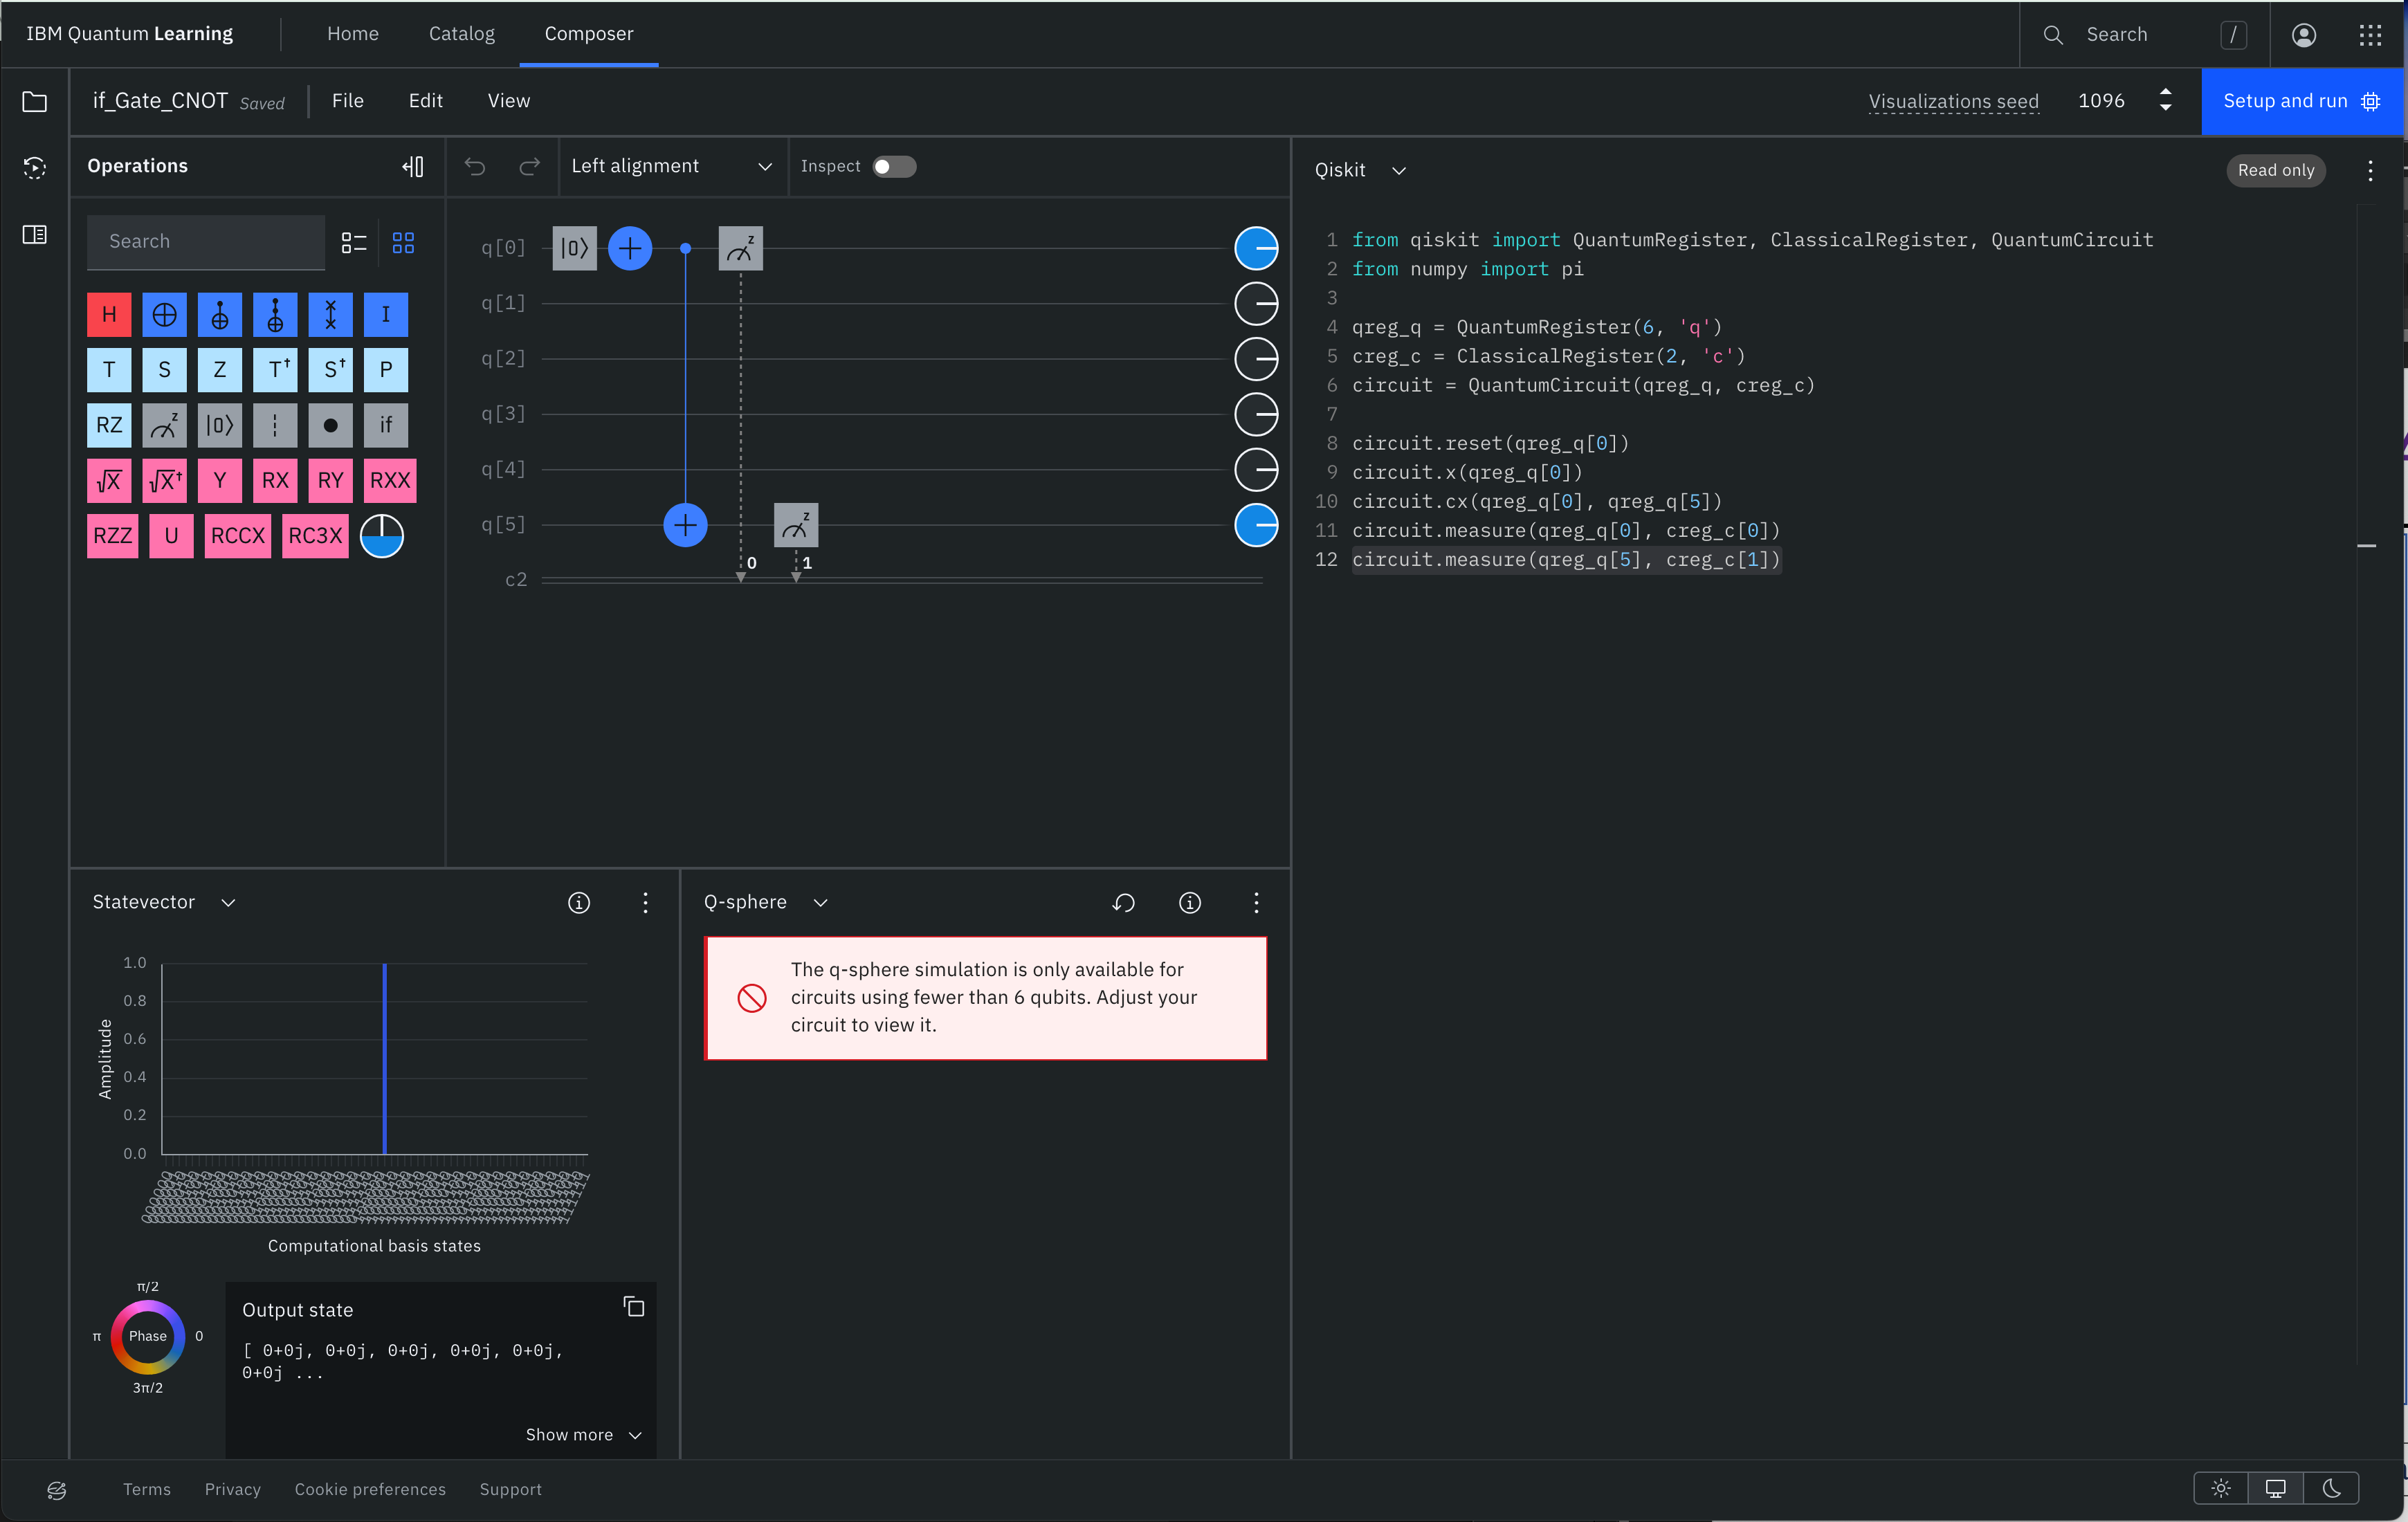

In [28]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi

qreg_q = QuantumRegister(6, 'q')
creg_c = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

circuit.reset(qreg_q[0])
circuit.x(qreg_q[0])
circuit.cx(qreg_q[0], qreg_q[5])
circuit.measure(qreg_q[0], creg_c[0])
circuit.measure(qreg_q[5], creg_c[1])

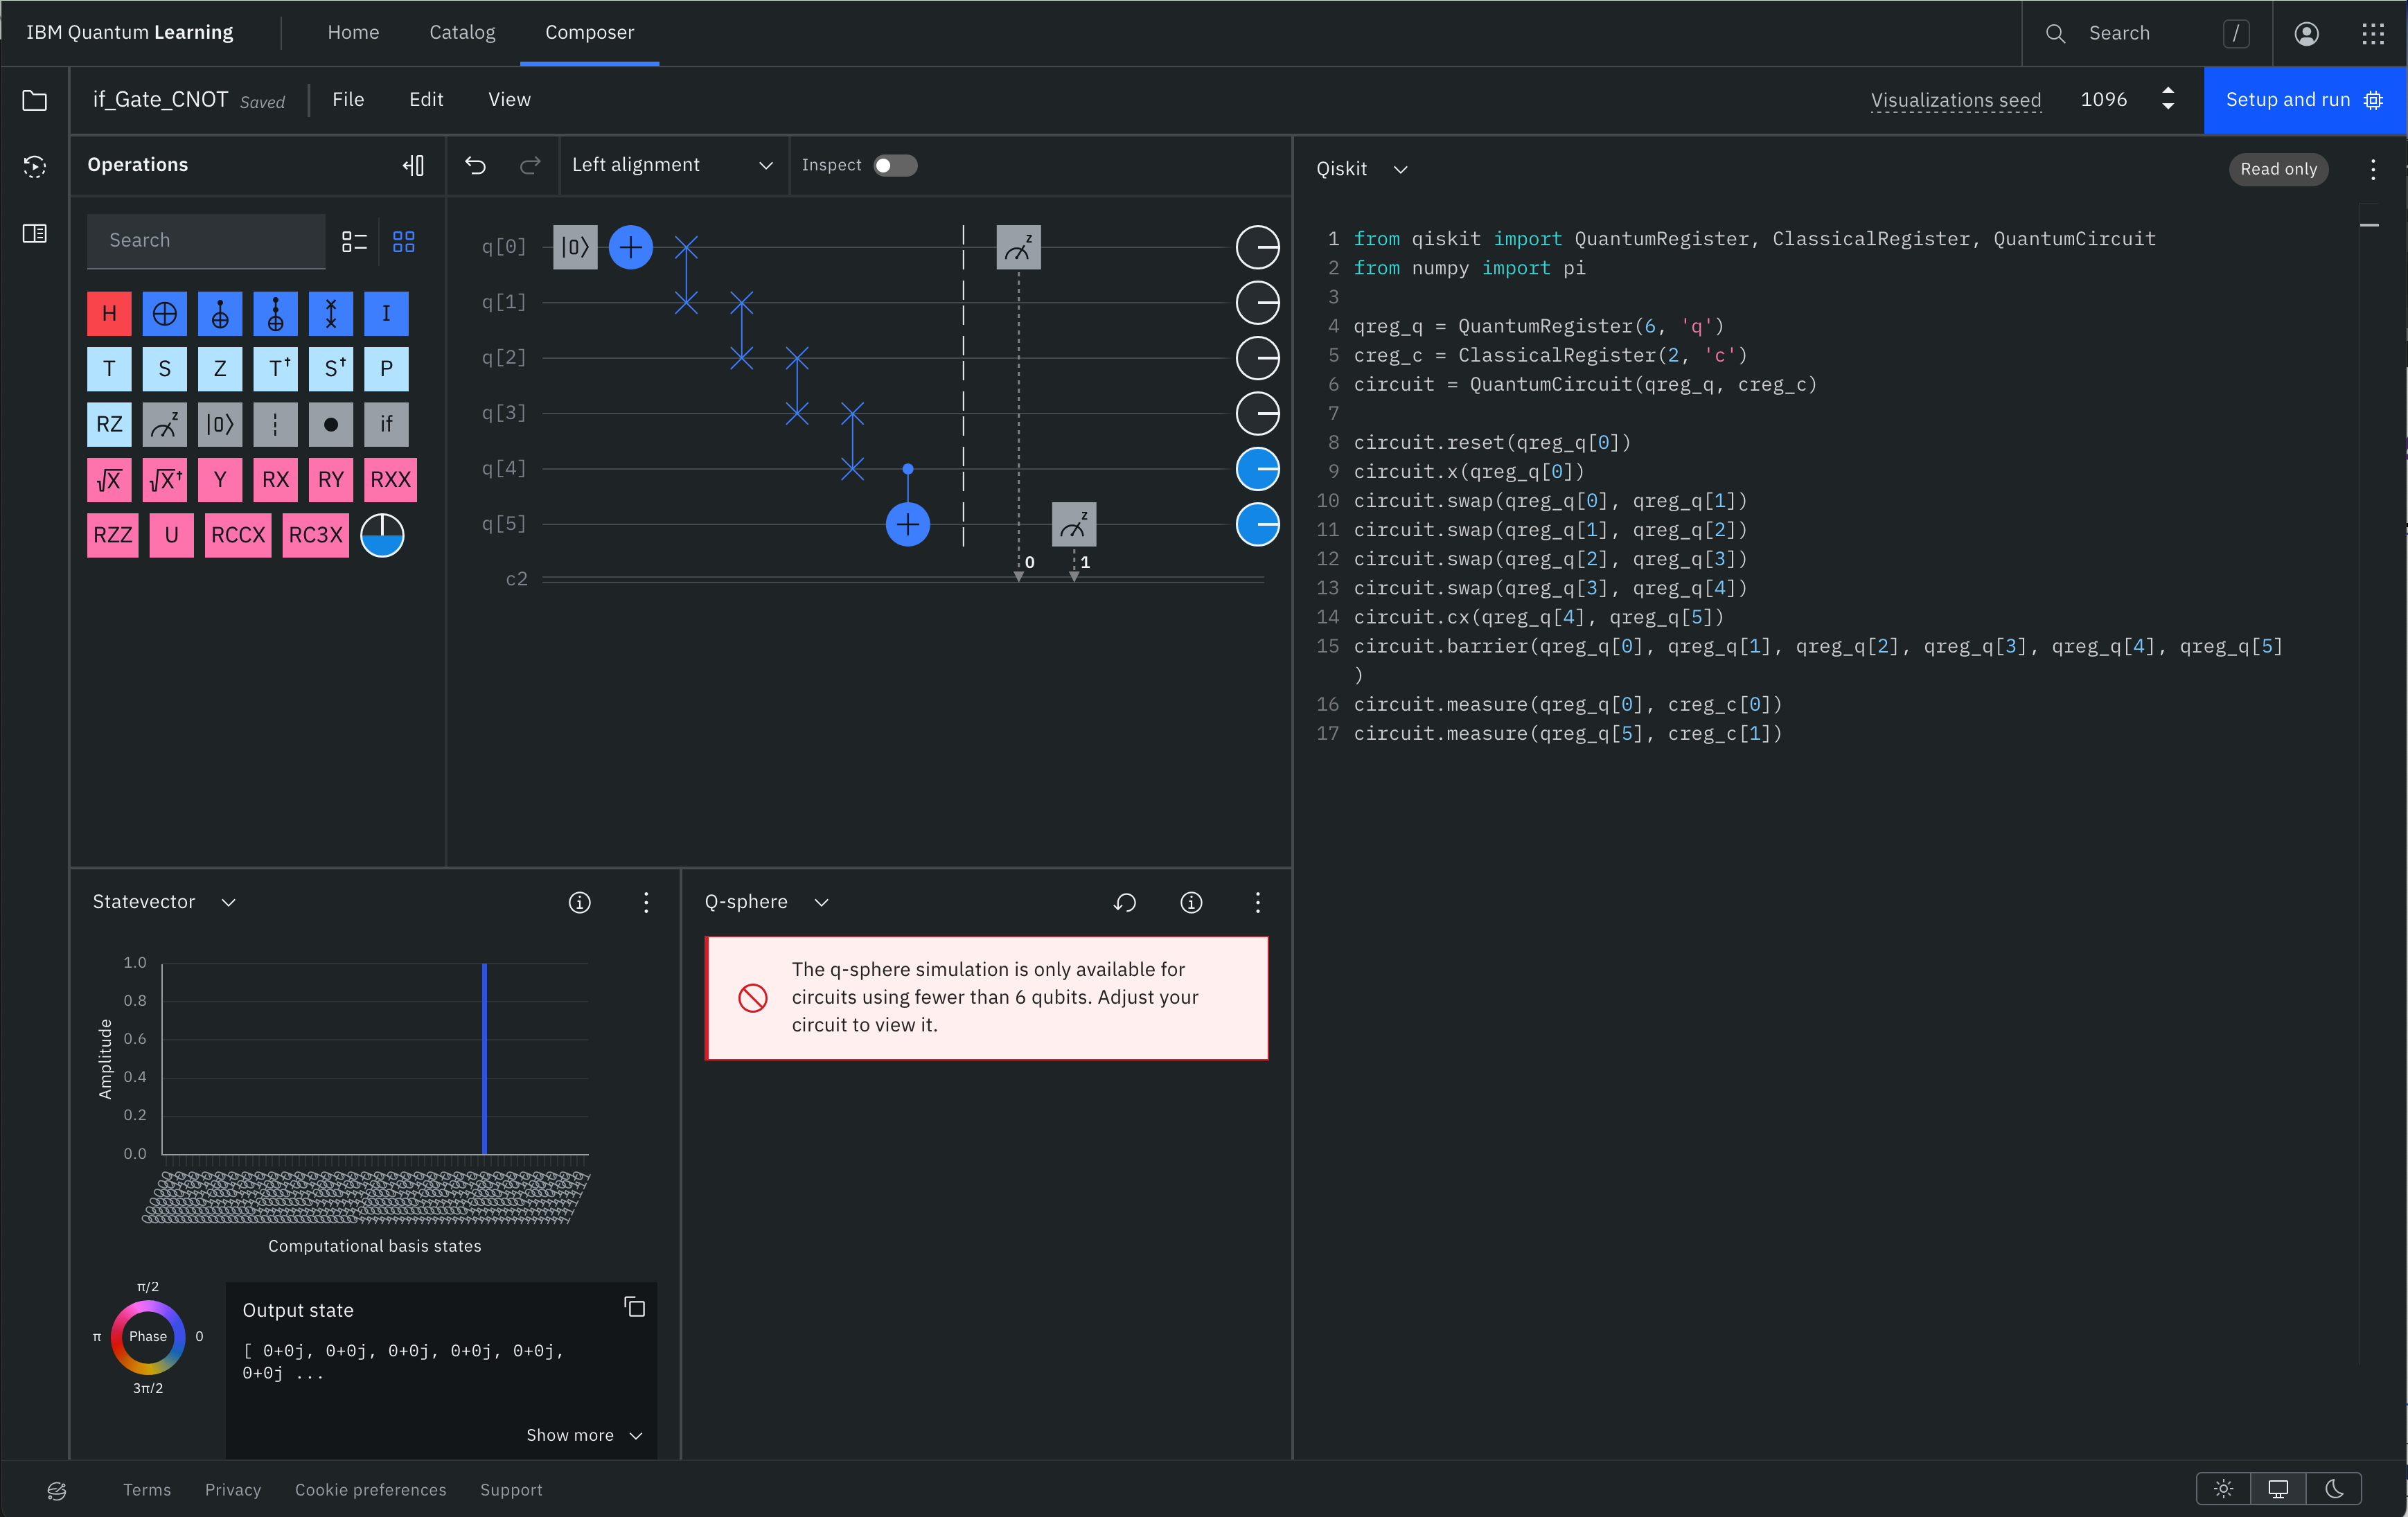

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi

qreg_q = QuantumRegister(6, 'q')
creg_c = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

circuit.reset(qreg_q[0])
circuit.x(qreg_q[0])
circuit.swap(qreg_q[0], qreg_q[1])
circuit.swap(qreg_q[1], qreg_q[2])
circuit.swap(qreg_q[2], qreg_q[3])
circuit.swap(qreg_q[3], qreg_q[4])
circuit.cx(qreg_q[4], qreg_q[5])
circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3], qreg_q[4], qreg_q[5])
circuit.measure(qreg_q[5], creg_c[1])
circuit.measure(qreg_q[0], creg_c[0])

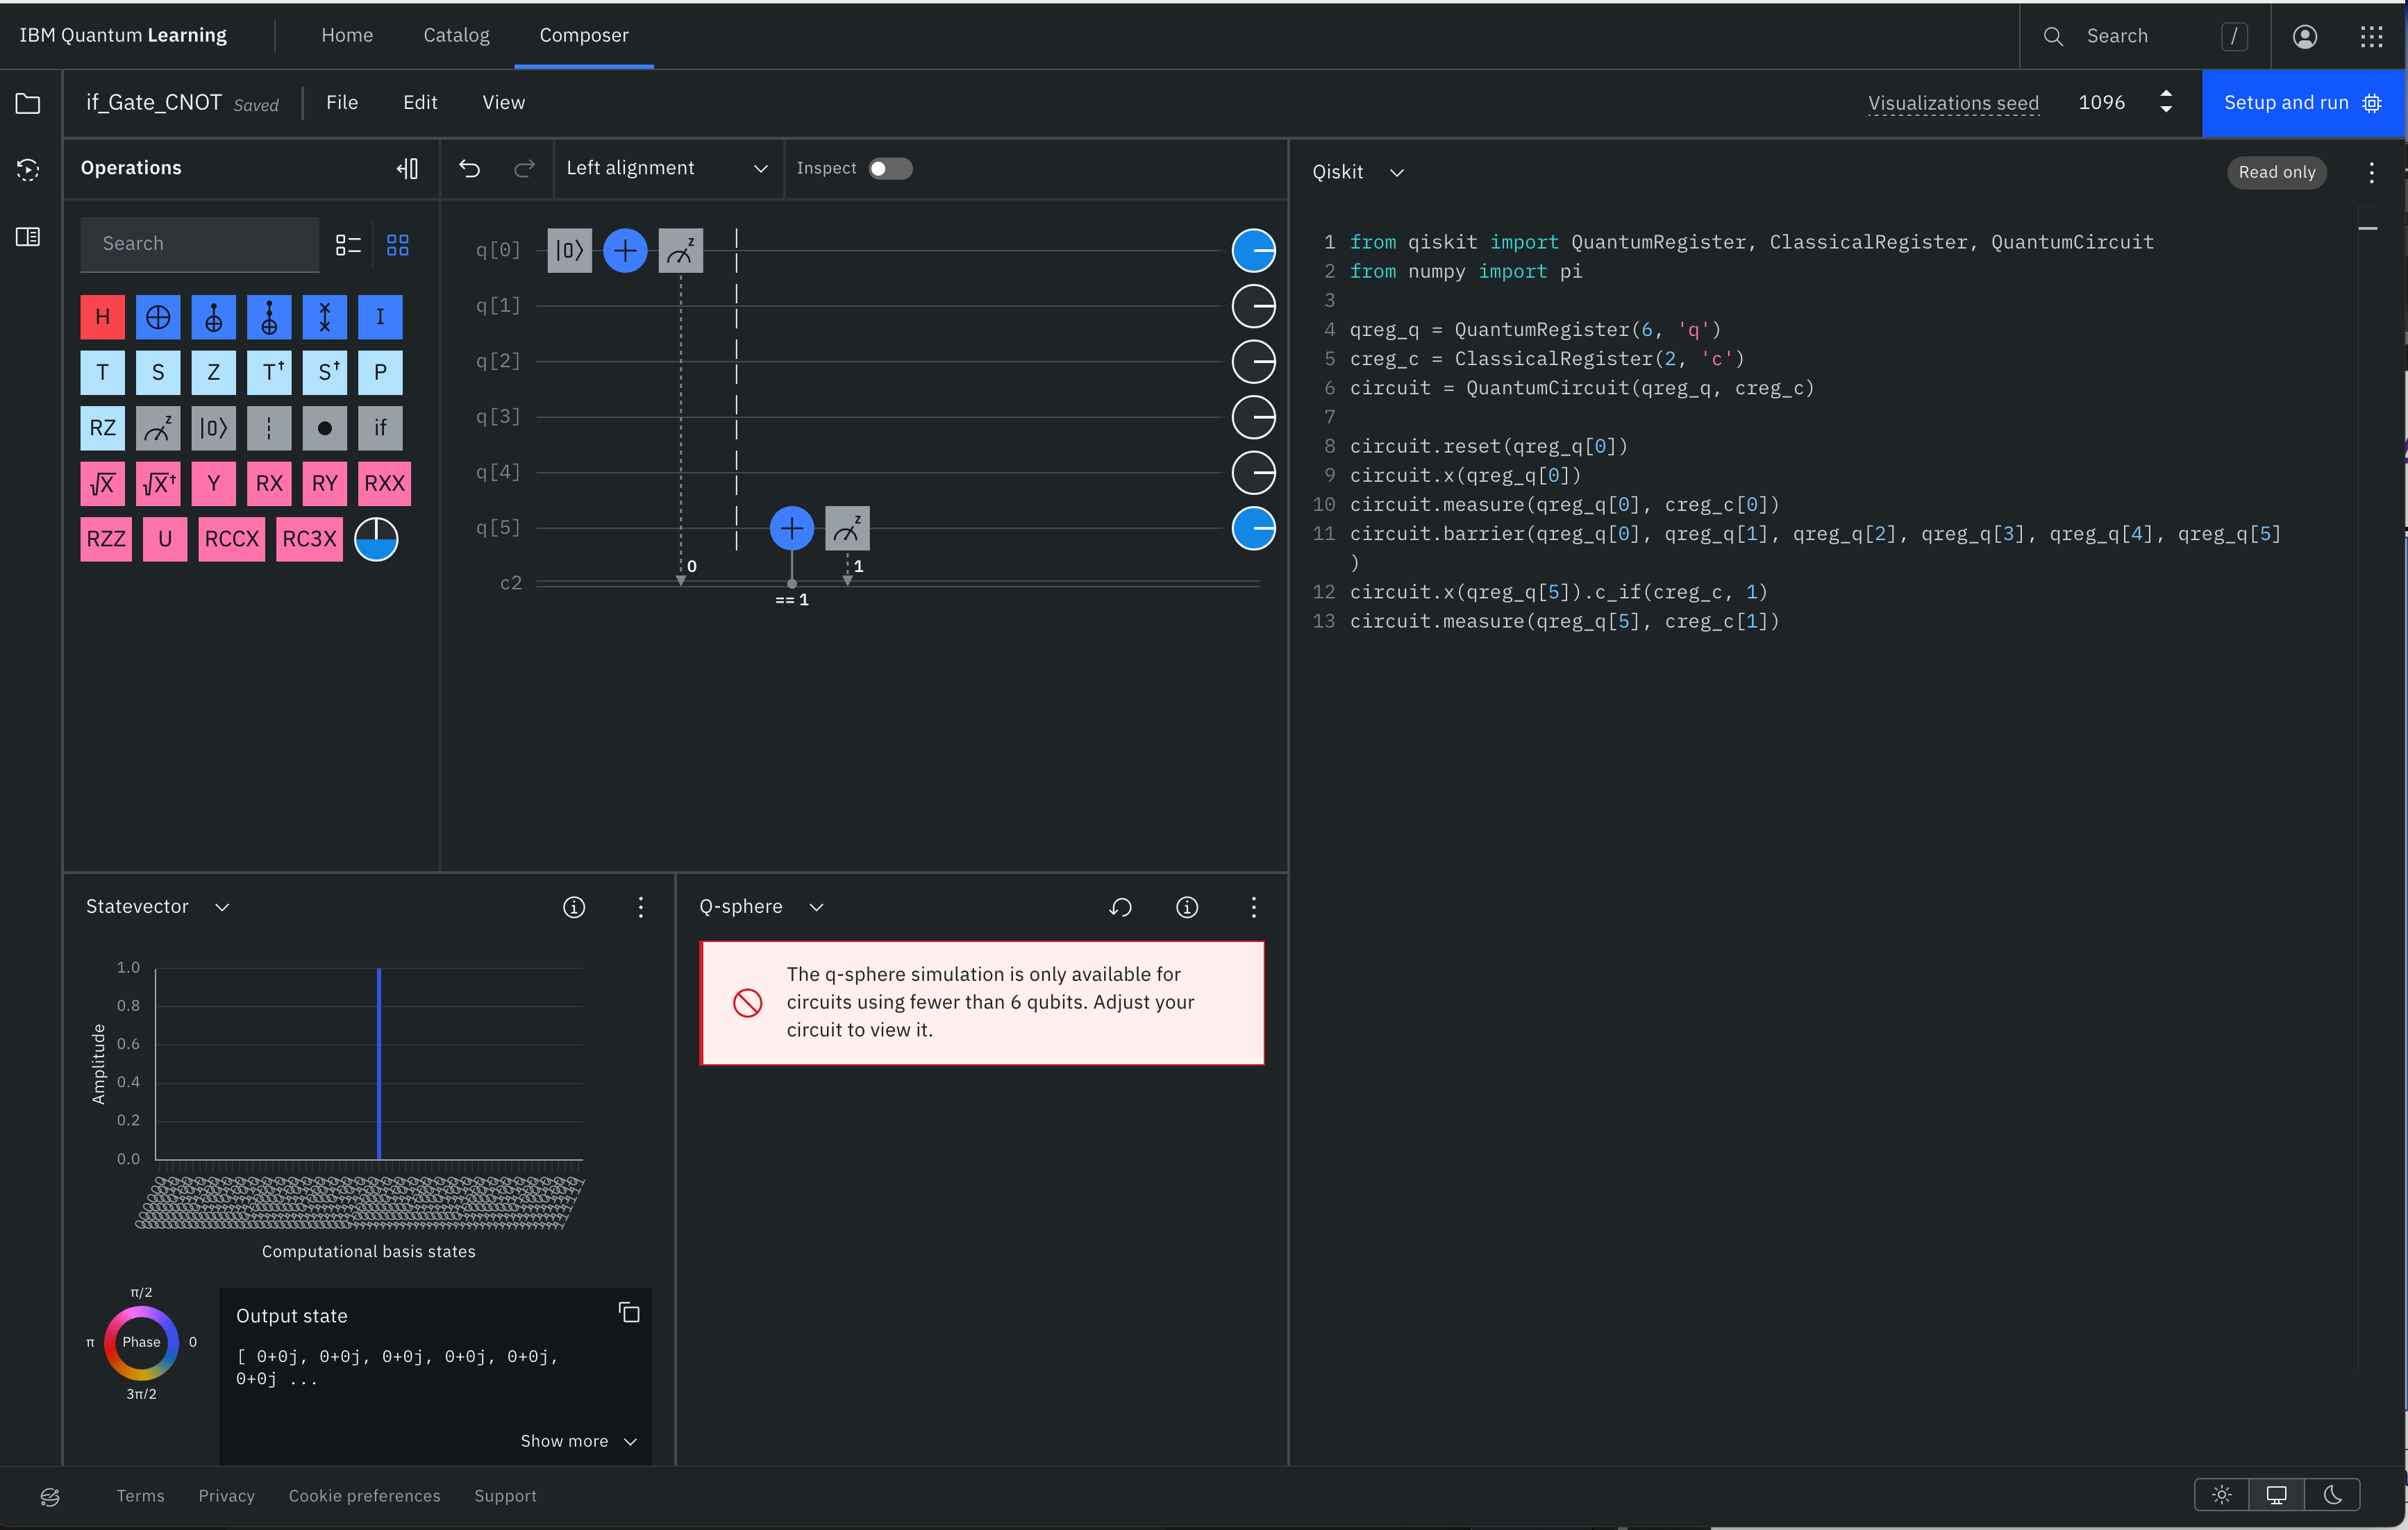

In [29]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi

qreg_q = QuantumRegister(6, 'q')
creg_c = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

circuit.reset(qreg_q[0])
circuit.x(qreg_q[0])
circuit.measure(qreg_q[0], creg_c[0])
circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3], qreg_q[4], qreg_q[5])
circuit.x(qreg_q[5]).c_if(creg_c, 1)
circuit.measure(qreg_q[5], creg_c[1])

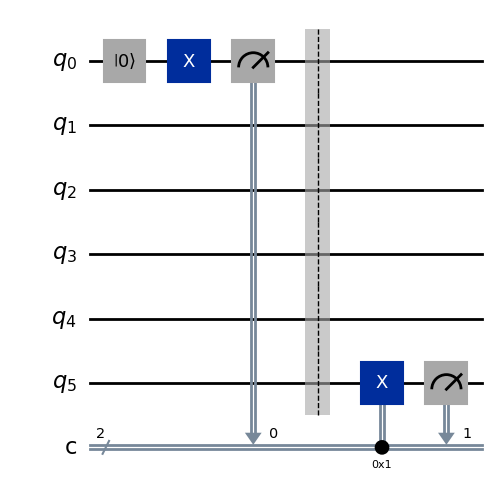

In [30]:
circuit.draw('mpl')

In [13]:
#sampler = QSampler(backend)
sampler = RSampler(backend)
#sampler = FakeManilaV2()
#sampler = AerSampler()

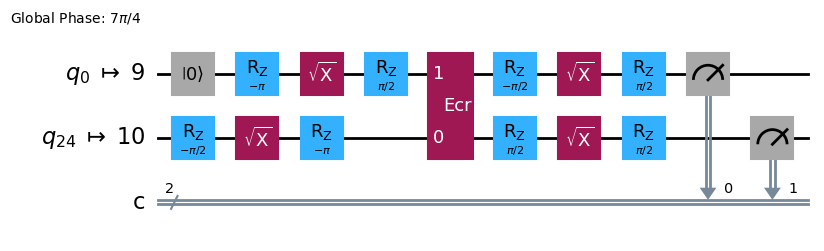

In [14]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuit)

isa_circuit.draw('mpl', idle_wires=False)

Qiskit-runtime-Service는 이전의 확률분포 반환에서 추가적으로 데이터를 반환하는 두 가지 방법을 제공합니다.
1.   측정하기로 선택한 큐비트 집합에 대한 확률 분포

```
# 회로 실행 및 결과 얻기
job = sampler.run(circuit)
result = job.result()
counts = result.quasi_dists[0]
# 결과 출력
print(counts)
```

2.   관측 가능한 값의 기대값

```
# 회로 실행 및 결과 얻기
job = estimator.run(observable, circuit)
result = job.result()
expectation_value = result.values[0]
# 결과 출력
print(expectation_value)
```


In [15]:
job = sampler.run([isa_circuit], shots=1024)

# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

# 서비스 플렛폼에서 Job이 완료될 때까지 기다립니다.

>>> Job ID: cybmsfdnrmz000865zag


In [21]:
job.status()

'DONE'

In [22]:
### 서비스 플렛폼에서 Job이 완료되면 그 Job.ID를 이용해 결과를 추출합니다. ###
#job = service.job("cybmsfdnrmz000865zag")

result = job.result()

In [23]:
result

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1024, num_bits=2>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([SliceSpan(<start='2025-01-27 09:07:11', stop='2025-01-27 09:10:19', size=1024>)])}, 'version': 2})

In [24]:
result[0].data.c.get_counts()

{'11': 972, '01': 39, '10': 8, '00': 5}

In [26]:
pub_result = job.result()[0]
counts = pub_result.data.c.get_counts()

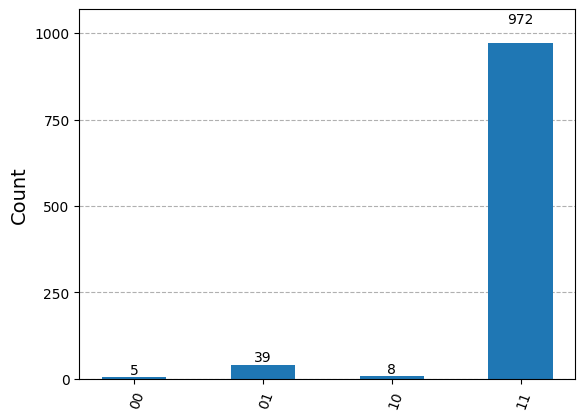

In [27]:
from qiskit.visualization import plot_histogram # Import plot_histogram
plot_histogram(counts)